
# Семинар 8 - Алгоритмы анализа стереопар изображений

***

Полезные материалы:

- [First Principles of Computer Vision - Camera Calibration | Uncalibrated Stereo](https://youtube.com/playlist?list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&si=iXEBEehuQr-IgIVC) - плейлист с серией лекций по калибровке камеры и стереозрению
- [Simple Stereo | Camera Calibration](https://youtu.be/hUVyDabn1Mg?si=HmalQZKI9ytoyxPn) - лекция из плейлиста выше, в которой доступно раскрывается тема данного семинара

На этом семинаре будет разобрана тема стереозрения, которая заключается в применении нескольких видов камер для получения информации о глубине обзора. Используя стереозрение, можно определить местоположение точки в мире по ее изображениям в разных ракурсах камеры.

Термин охватывает многие приложения, работающие с несколькими видами отслеживаемого объекта под разными углами. Это могут быть стереокамеры, которые имеют несколько камер на одних и тех же устройствах, или разные виды с разных устройств.

1. **3D реконструкция с нескольких ракурсов**: знаем параметры калибровки каждой из камер, необходимо найти положение 3D объекта в мировых координатах.

2. **Оценка на основе движения (Structure From Motion)**: не знаем параметры калибровки, необходимо одновременно восстановить и координаты, и калибровку.

Первая задача проще в своей постановке, рассмотрим ее.

## Моно/Стерео зрение

_Источник изображений: https://github.com/polygon-software/python-visual-odometry_

![1_projection_and_stereo](data/1_projection_and_stereo.png)

**Идея:** можем найти пересечение лучей, исходящих из разных камер, и по параметрам камеры определить расстояние до объекта. Вы можете ощутить эффект стереовидения на основе своих глаз. Поставьте палец перед глазами. Закройте один глаз, потом другой глаз. Вы заметите, что пальцы, кажется, прыгают слева направо. Это наблюдаемое горизонтальное смещение называется диспаратностью (расхождением, disparity).

![3_stereo_cases](data/3_stereo_cases.png)

Рассмотрим более простой случай с выровненными (ректифицированными) камерами.

![4_stereo_vision_simple](data/4_stereo_vision_simple.png)

## Вопрос 1

Зная $f$ (фокальное расстояние камер), $b$ (расстояние между камерами), $u_l$, $u_r$, определить расстояние до объекта $Z_{p}$.

**Ответ:**

$$Z_{p} = \frac{f * b}{u_l = u_r}$$

Эта формула является прямым следствием подобия треугольников, формирующихся между камерами, объектом и его проекциями на каждую из камер.

## Расчет диспаратности с помощью OpenCV

In [5]:
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png -O data/tsukuba_l.png
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png -O data/tsukuba_r.png

--2024-04-08 13:25:58--  https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85192 (83K) [image/png]
Saving to: ‘data/tsukuba_l.png’

data/tsukuba_l.png  100%[===================>]  83.20K  --.-KB/s    in 0.008s  

2024-04-08 13:25:58 (9.97 MB/s) - ‘data/tsukuba_l.png’ saved [85192/85192]

--2024-04-08 13:25:58--  https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, 

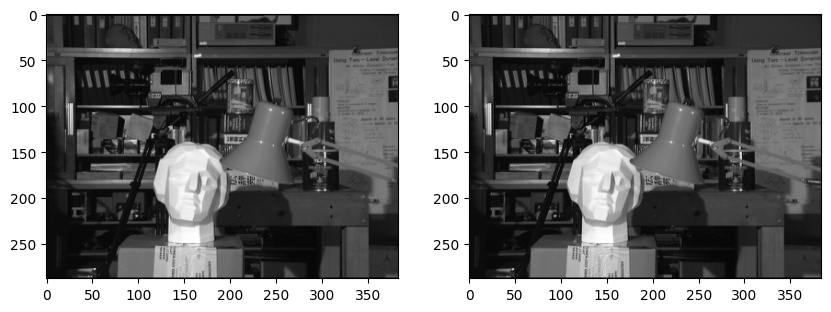

In [7]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('data/tsukuba_l.png',0)
imgR = cv2.imread('data/tsukuba_r.png',0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(imgL, cmap="gray")
ax[1].imshow(imgR, cmap="gray");

### cv2.StereoBM_create

https://docs.opencv.org/4.5.0/d9/dba/classcv_1_1StereoBM.html#a04fdf00525f82fe708d556e2cd359004

Чем меньше `blockSize` - тем детальнее карта диспаратности, однако и количество шума растет.

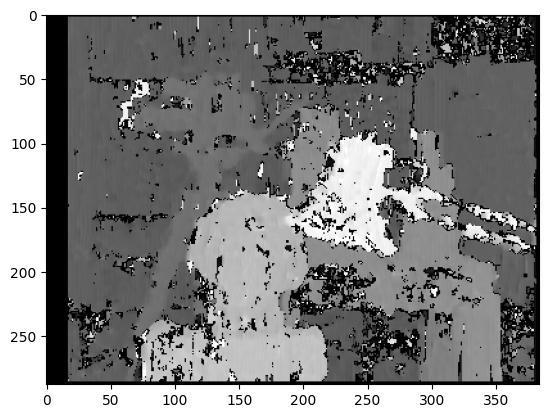

In [8]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=5,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray');

При слишком больших значениях `blockSize` шум отсутствует, однако детализация крайне низка:

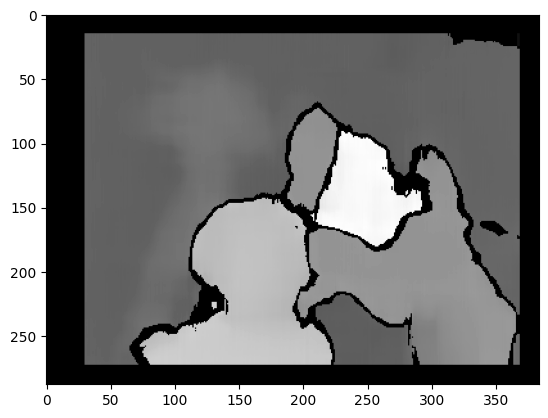

In [9]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=31,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray');

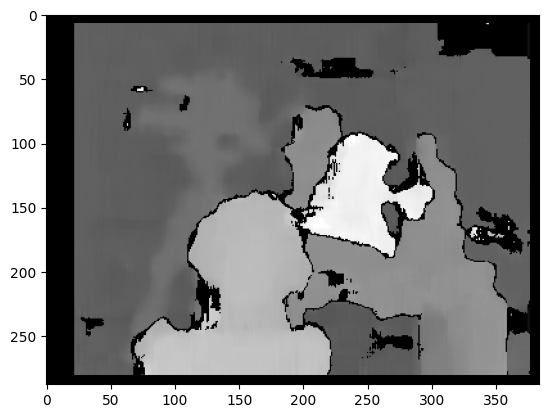

In [10]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=15,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray');

## Задание 1 - реализация алгоритма расчета диспаратности

Рассмотрим базовый жадный алгоритм наилучшего соответсвия (winner takes all, WTA) между изображениями с помощью блоков и метрики близости (sum of absolute difference, SAD).

![alg](data/alg.png)

**Заполните пропуски в коде**

In [11]:
import numpy as np

def compare_blocks(block_left: np.array, block_right: np.array) -> float:
    '''
    Takes blocks from left/right image and returns the sum of absolute differences.
    '''
    # Ensure the blocks are the same shape
    assert block_left.shape == block_right.shape, 'Blocks are not equal'

    # Calculate Sum of Absolute Differences (SAD)
    sad = np.sum(np.abs(block_left - block_right))
    return sad

def get_disparity(imgL: np.array, imgR: np.array, numDisparities: int, blockSize: int) -> np.array:
    assert imgL.shape == imgR.shape, 'Images are not equal'

    H, W = imgL.shape
    disparity_map = np.zeros_like(imgL)

    half_block_size = blockSize // 2

    for i in range(half_block_size, H - half_block_size):
        for j in range(half_block_size, W - half_block_size):

            # Extract the block from the left image
            block_left = imgL[i - half_block_size:i + half_block_size + 1,
                              j - half_block_size:j + half_block_size + 1]

            min_sad = np.inf
            min_k = 0

            for k in range(numDisparities):
                j_right = j - k

                # Check bounds for the right image
                if j_right - half_block_size >= 0:
                    block_right = imgR[i - half_block_size:i + half_block_size + 1,
                                       j_right - half_block_size:j_right + half_block_size + 1]

                    sad = compare_blocks(block_left, block_right)

                    if sad < min_sad:
                        min_sad = sad
                        min_k = k

            # The disparity for the current pixel
            disparity_map[i, j] = min_k

    return disparity_map

## Вопрос 2

Заполняет ли алгоритм все пиксели глубины? Как можно улучшить его? (Например, рассмотрите вариант, когда `metrics.min()` выдает большое число, что делать в этом случае? Или предложите свою версию.)

**Ответ:**
Приведенный базовый алгоритм расчета диспаратности не гарантирует, что все пиксели глубины будут точно заполнены значимыми значениями диспаратности. В частности, существуют сценарии и граничные случаи, когда алгоритм может давать менее надежные результаты:

- вблизи краев объектов или в окклюзированных областях диспаратность может быть неверной из-за отсутствия соответствующих элементов на другом изображении.  
- в областях с малым количеством или полным отсутствием текстуры многие блоки могут иметь одинаковое значение SAD, что приводит к неоднозначному совпадению.  
- использование блоков небольшого размера может сделать диспаратность чувствительной к шуму, а большие блоки могут не улавливать мелкие детали.

Для улучшения расчета карты диспарантности, чтобы справиться со случаями, когда metrics.min() выдает большое число можно:

1. Confidence Thresholding. Если минимальное значение SAD превышает определенный порог, это говорит о низком уровне доверия к совпадению. В таких случаях можно присвоить значение диспаритета по умолчанию (например, 0 или среднее значение диспаритета близлежащих пикселей).

2. Постобработка. Можно использовать медианную фильтрацию для удаления изолированного шума и сглаживания карты диспаратности с сохранением краев.

3. Другие критерии. Помимо SAD, есть другие критерии сопоставления, такие как сумма квадратичных разниц (SSD) или нормализованная кросс-корреляция, которые при определенных условиях могут работать лучше.

## Задание 2

Сравните свою реализацию с opencv StereoBM с помощью попиксельного сравнения карт диспаратности.

In [ ]:
imgL = cv2.imread('data/tsukuba_l.png',0)
imgR = cv2.imread('data/tsukuba_r.png',0)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_OpenCV = stereo.compute(imgL, imgR)
disparity_custom = get_disparity(imgL, imgR, numDisparities=16, blockSize=15)

disparity_OpenCV_norm = cv2.normalize(disparity_OpenCV, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_custom_norm = cv2.normalize(disparity_custom, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

disparity_difference = np.abs(disparity_OpenCV_norm.astype(np.float32) - disparity_custom_norm.astype(np.float32))

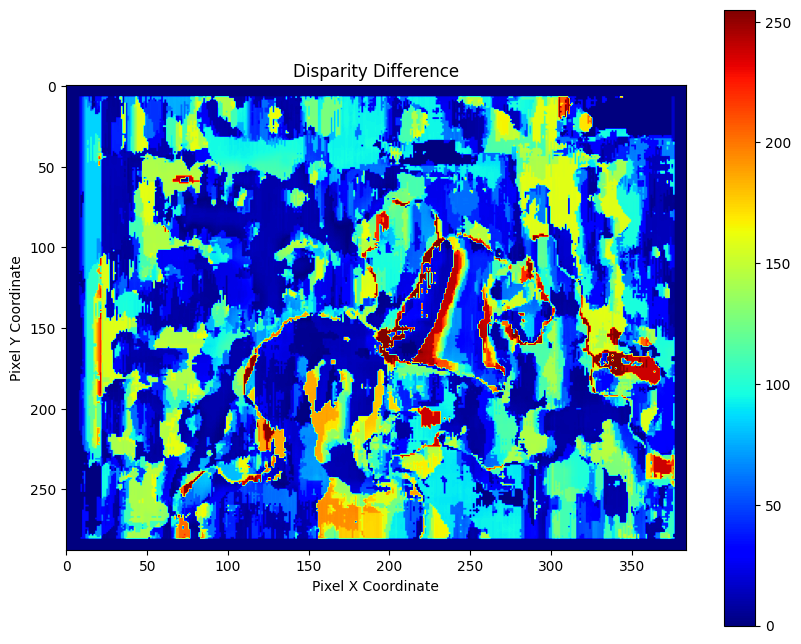

In [18]:
plt.figure(figsize=(10, 8))
plt.imshow(disparity_difference, cmap='jet')
plt.colorbar()
plt.title('Disparity Difference')
plt.xlabel('Pixel X Coordinate')
plt.ylabel('Pixel Y Coordinate')
plt.show()

Видно, что в целом карты диспаратности во многом имеют схожие значения, но есть сложные места, где абсолютная разность значений достигает максимальных значений.


## Вопрос 3

Как еще с помощью пройденных классических алгоритмов можно построить карту диспаратности? Приведите краткое описание придуманного/существующего алгоритма.

**Ответ:**

Полуглобальное сопоставление (SGM) - метод, который улучшает базовое сопоставление блоков, вводя ограничение на гладкость по нескольким направлениям в изображении.

**Краткое описание алгоритма**

1) Для каждого пикселя и возможной диспарантности рассчитать стоимость сопоставления, используя меры, такие как SAD или SSD (аналогичен начальному шагу в блочном сопоставлении).

2) Агрегировать стоимость вдоль нескольких путей через изображение (например, горизонтально, вертикально и диагонально). Для каждого пути алгоритм итеративно сочетает текущую стоимость пикселя с минимальными стоимостями его соседей, включая штраф за изменения диспарантности, чтобы обеспечить гладкость. Этот процесс повторяется для нескольких направлений.

3) Для каждого пикселя выбрать диспарантность с наименьшей агрегированной стоимостью из всех путей.

4) Применить постобработку, например, медианные фильтры, чтобы уточнить карту диспарантности и уменьшить ошибки.
